In [1]:
%load_ext autoreload
#import race
#import math
#import random

#import gym
import numpy as np

#import torch
#import torch.nn as nn
#import torch.optim as optim
#import torch.nn.functional as F
#from torch.distributions import Normal

#from IPython.display import clear_output
import matplotlib.pyplot as plt
import optuna
#import importlib
import CurvyRaceEnv
#importlib.reload(CurvyRaceEnv)
%matplotlib inline
%reload_ext autoreload

In [2]:
from stable_baselines3.common.env_checker import check_env
#import CurvyRaceEnv
test = CurvyRaceEnv.CurvyRaceEnv()
check_env(test)

C:\Studium\MasterStudium\DRL\Studienarbeiten\Studienarbeit2\DRL_Studienarbeit2_env\Lib\site-packages\stable_baselines3\common\env_checker.py:441: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [3]:
from gymnasium.envs.registration import register

register(
     id="CurvyRaceEnv-v0",
     entry_point="CurvyRaceEnv:CurvyRaceEnv",
     max_episode_steps=100,
)

In [4]:
from typing import Any
from typing import Dict

import gymnasium
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import StopTrainingOnNoModelImprovement
from stable_baselines3.common.callbacks import EvalCallback, BaseCallback

import torch
import torch.nn as nn
import time
N_TRIALS = 10000
N_STARTUP_TRIALS = 5
N_EVALUATIONS = 2
N_TIMESTEPS = 20000
EVAL_FREQ = int(N_TIMESTEPS / N_EVALUATIONS)
N_EVAL_EPISODES = 3

ENV_ID = "CurvyRaceEnv-v0"

DEFAULT_HYPERPARAMS = {
    "policy": "MlpPolicy",
    "env": ENV_ID,
}

In [5]:
def evaluate_model(model, env, num_episodes=100):  
    
    total_reward = 0.0
    for _ in range(num_episodes):
        obs, info = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done,info, _ = env.step(action)
            total_reward += reward
    mean_reward = total_reward / num_episodes
    return mean_reward

In [6]:
from stable_baselines3 import A2C, PPO, TD3, DDPG, SAC
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

def objective(trial: optuna.Trial) -> float:   
    hyperparams = {
        'learning_starts': trial.suggest_int('learning_starts', 50,400),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'gamma': trial.suggest_float('gamma', 0.9, 0.999),
        'tau': trial.suggest_float('tau', 1e-3, 1e-1, log=True)   
    }
    # Define the environment
    env = gymnasium.make('CurvyRaceEnv-v0')  
    


    
    
    

    # Create and train the DDPG model
    model = SAC('MlpPolicy', env, learning_starts=hyperparams['learning_starts'] ,learning_rate=hyperparams['learning_rate'],
                 gamma=hyperparams['gamma'], tau=hyperparams['tau'],
                 action_noise=NormalActionNoise(mean=np.zeros(env.action_space.shape), sigma=0.1 * np.ones(env.action_space.shape)))
    
    # Train the model
    model.learn(total_timesteps=50000)  # Adjust the total_timesteps as needed

    # Evaluate the model
    mean_reward = evaluate_model(model, env)

    return mean_reward

In [7]:
#study = optuna.create_study(study_name="SAC", storage="sqlite:///DRL2.db", load_if_exists=True, direction="maximize")
#study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

In [8]:
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

eval_env = gymnasium.make("CurvyRaceEnv-v0")
eval_callback = EvalCallback(eval_env, best_model_save_path='model/best_model',
                            log_path='logs/best_model_log', eval_freq=1000,
                            deterministic=True, render=False,
                            callback_on_new_best=StopTrainingOnRewardThreshold(reward_threshold=3500, verbose=1))

In [9]:
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3 import DDPG, TD3, SAC, A2C,PPO
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise


env = gymnasium.make("CurvyRaceEnv-v0")
#env = Monitor(env, "logs/ddpg")
#model_ddpg = DDPG("MlpPolicy", env,action_noise=NormalActionNoise(mean=np.zeros(env.action_space.shape), sigma=0.1 * np.ones(env.action_space.shape)),  learning_rate=0.004859847958257243,tau=0.06431401009446525,  gamma = 0.9903705891833702, buffer_size=2000000)
#model_ddpg.learn(total_timesteps=200000)
#model_ddpg.save("models/model_ddpg")
#_, _ = env.reset()
#del model_ddpg

#env = Monitor(env, "logs/td3")
#model_td3 = TD3("MlpPolicy", env, action_noise=NormalActionNoise(mean=np.zeros(env.action_space.shape), sigma=0.1 * np.ones(env.action_space.shape)), learning_rate=0.004859847958257243,tau=0.06431401009446525,  gamma = 0.9703705891833702, buffer_size=200000)
#model_td3.learn(total_timesteps=200000)
#model_td3.save("models/model_td3")
#_, _ = env.reset()
#del model_td3

env = Monitor(env, "logs/sac3")
model_sac = SAC("MlpPolicy", env,action_noise=NormalActionNoise(mean=np.zeros(env.action_space.shape), sigma=0.1 * np.ones(env.action_space.shape)),  learning_rate=0.006859847958257243,tau=0.06431401009446525,  gamma = 0.9903705891833702, buffer_size=2000000)
model_sac.learn(total_timesteps=50000)
model_sac.save("models/model_sac3")
_, _ = env.reset()
del model_sac

#env = Monitor(env, "logs/a2c")
#model_a2c = A2C("MlpPolicy", env,  learning_rate=0.004859847958257243,  gamma = 0.9703705891833702)
#model_a2c.learn(total_timesteps=20000)
#model_a2c.save("models/model_a2c")
#_, _ = env.reset()
#del model_a2c

#env = Monitor(env, "logs/ppo")
#model_ppo = PPO("MlpPolicy", env,  learning_rate=0.004859847958257243,  gamma = 0.9703705891833702)
#model_ppo.learn(total_timesteps=50000)
#model_ppo.save("models/model_ppo")
#_, _ = env.reset()
#del model_ppo

C:\Studium\MasterStudium\DRL\Studienarbeiten\Studienarbeit2\DRL_Studienarbeit2_env\Lib\site-packages\gymnasium\utils\passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(


In [19]:
env.close()

In [20]:
def run_env(env, model):
    obs, info = env.reset()
    done = False
    reward_list = []
    observation_list = []
    while not done:
        action, _states = model.predict(obs)
        obs, rewards, done, info, _ = env.step(action)
        print(f"obs: {obs}")
        observation_list.append(obs)
        reward_list.append(rewards)
    env.render()
    return reward_list

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cumulative_rewards(rewards):
    """
    Plots the cumulative rewards per episode.
    """
    # Calculate the cumulative sum of the list elements
    cumulative_rewards = {key: np.cumsum(value) for key, value in rewards.items()}

    # Plot the cumulative rewards
    for key, value in cumulative_rewards.items():
        plt.plot(value, label=key)

    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.show()


In [22]:
import pandas as pd
def load_log(path):
    data =  pd.read_csv(path, index_col=None).index.tolist()[1:]    
    return [float(x) for x in data]

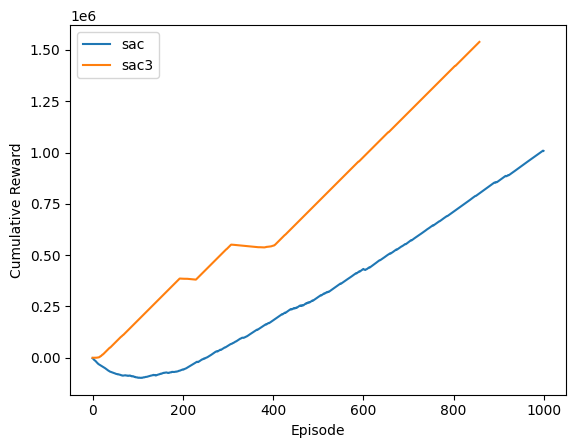

In [23]:
from stable_baselines3 import DDPG,SAC, TD3, A2C, PPO
sac = SAC.load("models/model_sac.zip")
sac2 = SAC.load("models/model_sac3.zip")

#ppo = PPO.load("models/model_ppo.zip")
#a2c = A2C.load("models/model_a2c.zip")
test = gymnasium.make("CurvyRaceEnv-v0")

rewards = {}
rewards["sac"] = load_log("logs/sac.monitor.csv")
rewards["sac3"] = load_log("logs/sac3.monitor.csv")

#rewards["test"] = load_log("logs/best_model_log/evaluations.npz")
#rewards["a2c"] = load_log("logs/a2c.monitor.csv")
#rewards["ppo"] = load_log("logs/ppo.monitor.csv")



plot_cumulative_rewards(rewards)

C:\Studium\MasterStudium\DRL\Studienarbeiten\Studienarbeit2\DRL_Studienarbeit2_env\Lib\site-packages\gymnasium\utils\passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(


obs: [ 0.75076824 -0.10349419  0.19918735 -0.11652985  1.2535114 ]
obs: [ 1.4920822   0.04615053  0.23559034 -0.32620373  0.51001006]
obs: [ 2.2194974   0.22076505  0.03082803 -0.15418874  1.7941368 ]
obs: [ 3.0110753   0.24517557  0.09910825 -0.34212962  1.0188637 ]
obs: [ 3.790618    0.32268864  0.15496042 -1.1501781   0.38466716]
obs: [4.423991   0.42162967 0.12226375 0.22946094 1.678784  ]
obs: [5.194895   0.51635563 0.33963236 0.20131768 0.9392053 ]
obs: [5.819761   0.73713547 0.04780319 0.9219476  0.31872222]
obs: [6.6097836  0.7749299  0.08362278 0.39711744 1.5679374 ]
obs: [7.379477   0.8394442  0.11999109 0.6966461  0.90630174]
obs: [ 8.100784    0.9264125   0.16252922 -0.12380233  1.9006406 ]
obs: [ 8.847944    1.0489285  -0.14091377  0.09846863  1.1530939 ]
obs: [ 9.6277485   0.93831027 -0.16358604  0.32781413  0.37732837]
obs: [10.400727    0.8107215  -0.3748087  -0.09436873  1.7930257 ]
obs: [11.1279545   0.52462643 -0.4034225  -0.13817583  1.0176917 ]
obs: [11.853268    0

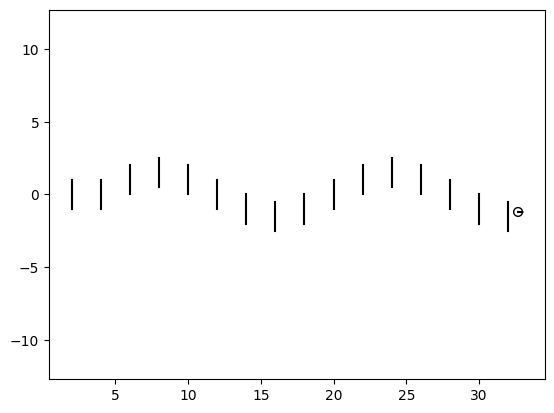

[-0.031271607855505604,
 0.12667257989440264,
 9.948941736626077,
 0.09828882692951867,
 0.5476128331226677,
 19.76535638558575,
 -0.16774493477033553,
 -0.4837396805246269,
 29.689445752109517,
 -0.41305887973403005,
 39.92614112188988,
 -0.13159817288417802,
 -0.19085909495471878,
 49.91911110277025,
 -0.003604354662498435,
 0.3186978904734982,
 60.0272378001776,
 0.1294456291318181,
 69.86275142660955,
 -0.035921616136261506,
 0.23152594214855232,
 79.82786905453978,
 -0.03327270532926474,
 0.15723441344959035,
 89.83292073904875,
 -0.14827829825348235,
 -0.32071491397812846,
 99.75864318368464,
 -0.32942684787878546,
 -0.6962994142713046,
 109.66993537770422,
 -0.4712683036472241,
 119.93026811737799,
 -0.14399889356781836,
 -0.30051209890622965,
 129.90235520813732,
 -0.06321182725220166,
 0.1632657049969774,
 140.12307412672723,
 0.21382595453827813,
 0.355114556966775,
 149.877413089676,
 0.09452812394992946,
 0.6402112840514934,
 1001]

In [25]:
run_env(test, sac2)

In [16]:
test.action_space

Box([-4. -2.], [4. 2.], (2,), float32)

In [17]:
test.observation_space

Box(-inf, inf, (5,), float32)

In [18]:
sum(rewards)

TypeError: unsupported operand type(s) for +: 'int' and 'str'